In [44]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

In [45]:
train_file = os.getenv('HOME') + '/aiffel/datathon/train.csv'
test_file = os.getenv('HOME') + '/aiffel/datathon/test.csv'

df_train = pd.read_csv(train_file, encoding='cp949')
df_test = pd.read_csv(test_file, encoding='cp949')
# submission = pd.read_csv('../datathon/sample_submission.csv')

train = df_train.copy()
test = df_test.copy()

# 한글 열 이름 변경
cols = ["num", "date_time", "energy", "temp", "windspeed", "humidity", "precipitation", "sun", "cooler", "solar"]
cols2 = ["num", "date_time", "temp", "windspeed", "humidity", "precipitation", "sun", "cooler", "solar"]

train.columns = cols
test.columns = cols2

for col in ['temp','windspeed','humidity','precipitation','sun']:
    test[col] = test[col].interpolate(method='linear')
test = test.fillna(0)

In [46]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["date"] = train["date_time"].dt.date # 전체 날짜
train["month"] = train["date_time"].dt.month # 월
train["day"] = train["date_time"].dt.day # 일
train["hour"] = train["date_time"].dt.hour
train["weekday"] = train["date_time"].dt.weekday # 0: 월요일
train["weekend"] = train["weekday"].isin([5, 6]).astype(int) # 5: 토요일


test["date_time"] = pd.to_datetime(test["date_time"])
test["date"] = test["date_time"].dt.date # 전체 날짜
test["month"] = test["date_time"].dt.month # 월
test["day"] = test["date_time"].dt.day # 일
test["hour"] = test["date_time"].dt.hour
test["weekday"] = test["date_time"].dt.weekday # 0: 월요일
test["weekend"] = test["weekday"].isin([5, 6]).astype(int) # 5: 토요일

---

In [47]:
train['THI'] = 1.8*train['temp'] - 0.55*(1-(train['humidity']/100))*(1.8*train['temp']-26) + 32
test['THI'] = 1.8*test['temp'] - 0.55*(1-(test['humidity']/100))*(1.8*test['temp']-26) + 32

train['sensible']=13.12+0.6215*train['temp']-13.947*train['windspeed']**0.16+0.486*train['temp']*train['windspeed']**0.1
test['sensible']=13.12+0.6215*test['temp']-13.947*test['windspeed']**0.16+0.486*test['temp']*test['windspeed']**0.1

---

In [48]:
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import spearmanr

In [49]:
new_train = train.copy()
new_test = test.copy()

daily = train.groupby(['num','weekday'])['energy'].median().reset_index().pivot('num','weekday','energy').reset_index()
hourly = train.groupby(['num','hour'])['energy'].median().reset_index().pivot('num','hour','energy').reset_index().drop('num',axis = 1)
train_cluster = pd.concat([daily, hourly], axis= 1)

for i in range(len(train_cluster)):
    # 요일 별 전력 중앙값에 대해 scaling
    train_cluster.iloc[i,1:8] = (train_cluster.iloc[i,1:8] - train_cluster.iloc[i,1:8].mean())/train_cluster.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    train_cluster.iloc[i,8:] = (train_cluster.iloc[i,8:] - train_cluster.iloc[i,8:].mean())/train_cluster.iloc[i,8:].std()

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(train_cluster.iloc[:,1:])

train_cluster['cluster'] = km_cluster
train_cluster['cluster'] = train_cluster['cluster'].map({0:1, 1:3, 2:2, 3:0})

new_train = new_train.merge(train_cluster[['num', 'cluster']], on = 'num', how = 'left')
new_test = new_test.merge(train_cluster[['num', 'cluster']], on = 'num', how = 'left')

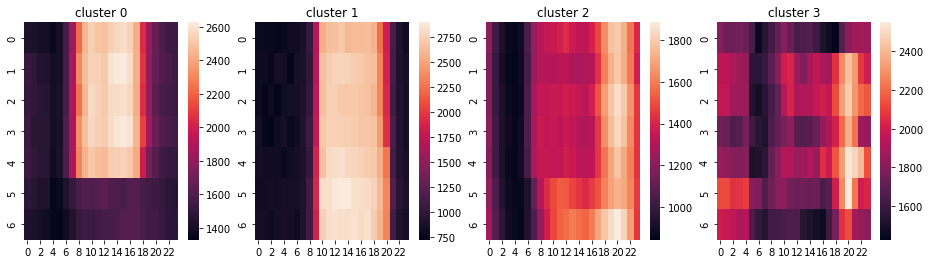

In [50]:
def draw_cluster(data):
    fig = plt.figure(figsize = (20, 4))
    for c in range(4):
        temp = data[data.cluster == c]
        temp = temp.groupby(['weekday', 'hour'])['energy'].median().reset_index().pivot('weekday', 'hour', 'energy')
        plt.subplot(1, 5, c+1)
        sns.heatmap(temp)
        plt.title(f'cluster {c}')
        plt.xlabel('')
        plt.ylabel('')
        
draw_cluster(new_train)

---

**Cluster의 전력사용량(kWh)과 기후 요소 상관관계**

In [51]:
type(new_train['cluster'][0])

numpy.int64

In [52]:
temp0 = new_train[new_train['cluster'] == 0][['energy','temp','windspeed','humidity','precipitation','sun']]
temp1 = new_train[new_train['cluster'] == 1][['energy','temp','windspeed','humidity','precipitation','sun']]
temp2 = new_train[new_train['cluster'] == 2][['energy','temp','windspeed','humidity','precipitation','sun']]
temp3 = new_train[new_train['cluster'] == 3][['energy','temp','windspeed','humidity','precipitation','sun']]

In [53]:
temp0.corrwith(temp0['energy'], method = 'spearman')

energy           1.000000
temp             0.206607
windspeed        0.094077
humidity        -0.098969
precipitation    0.000018
sun              0.165935
dtype: float64

In [54]:
temp1.corrwith(temp1['energy'], method = 'spearman')

energy           1.000000
temp             0.282354
windspeed        0.375138
humidity        -0.099573
precipitation   -0.027321
sun              0.302603
dtype: float64

In [55]:
temp2.corrwith(temp2['energy'], method = 'spearman')

energy           1.000000
temp             0.480547
windspeed        0.056694
humidity        -0.154517
precipitation    0.015814
sun              0.091813
dtype: float64

In [56]:
temp3.corrwith(temp3['energy'], method = 'spearman')

energy           1.000000
temp             0.086846
windspeed        0.241177
humidity        -0.037969
precipitation   -0.002331
sun             -0.005307
dtype: float64

**요약**


|항목|Cluster 0|Cluster 1|Cluster 2|Cluster 3|
|:---:|:---:|:---:|:---:|:---:|
|기온(°C)|**0.21**|**0.28**|**0.48**|0.09|
|풍속(m/s)|0.09|**0.38**|0.06|**0.24**|
|습도(%)|-0.10|-0.10|-0.15|-0.04|
|강수량(mm)|0.00|-0.03|0.02|-0.00|
|일조(hr)|0.17|**0.30**|0.09|0.01|

---

In [57]:
def draw_4chart(data, col = 'temp'):
    fig = plt.figure(figsize = (20, 4))
    for c in range(4):
        temp = data[data.cluster == c]
        temp = temp.groupby([col])[['energy']].mean().reset_index()
        plt.subplot(1, 5, c+1)
        sns.regplot(data = temp, x = col, y = 'energy')
        plt.title(f'cluster {c}')
        plt.xlabel('')
        plt.ylabel('')

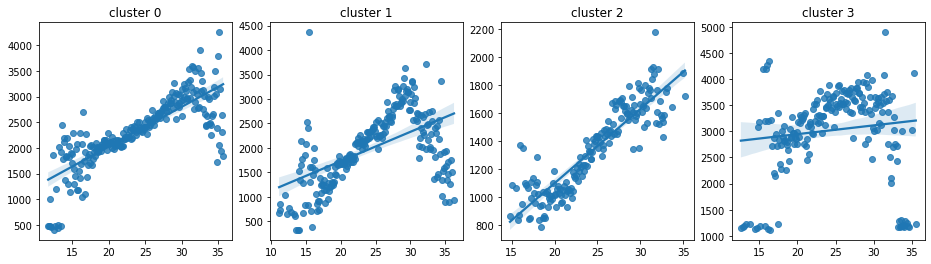

In [58]:
draw_4chart(new_train, 'temp')

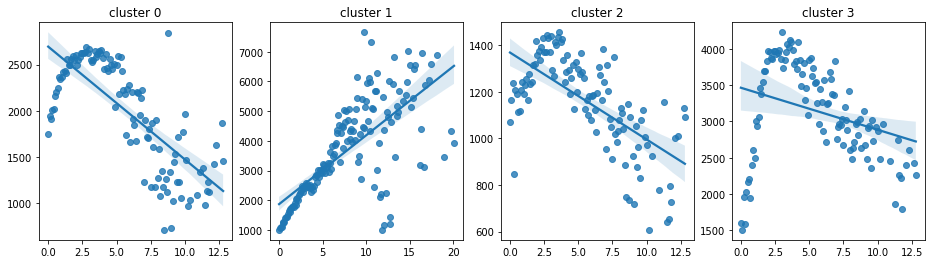

In [59]:
draw_4chart(new_train, 'windspeed')

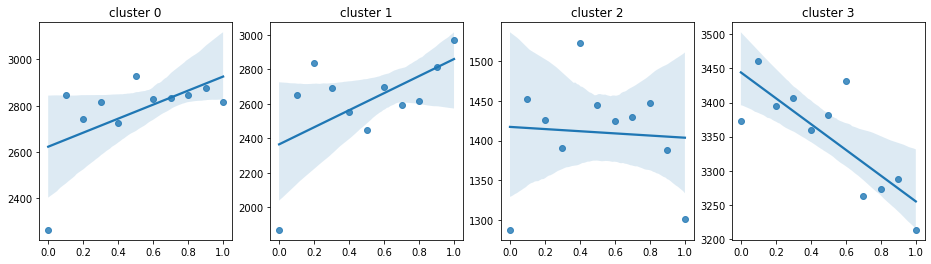

In [60]:
draw_4chart(new_train, 'sun')

---

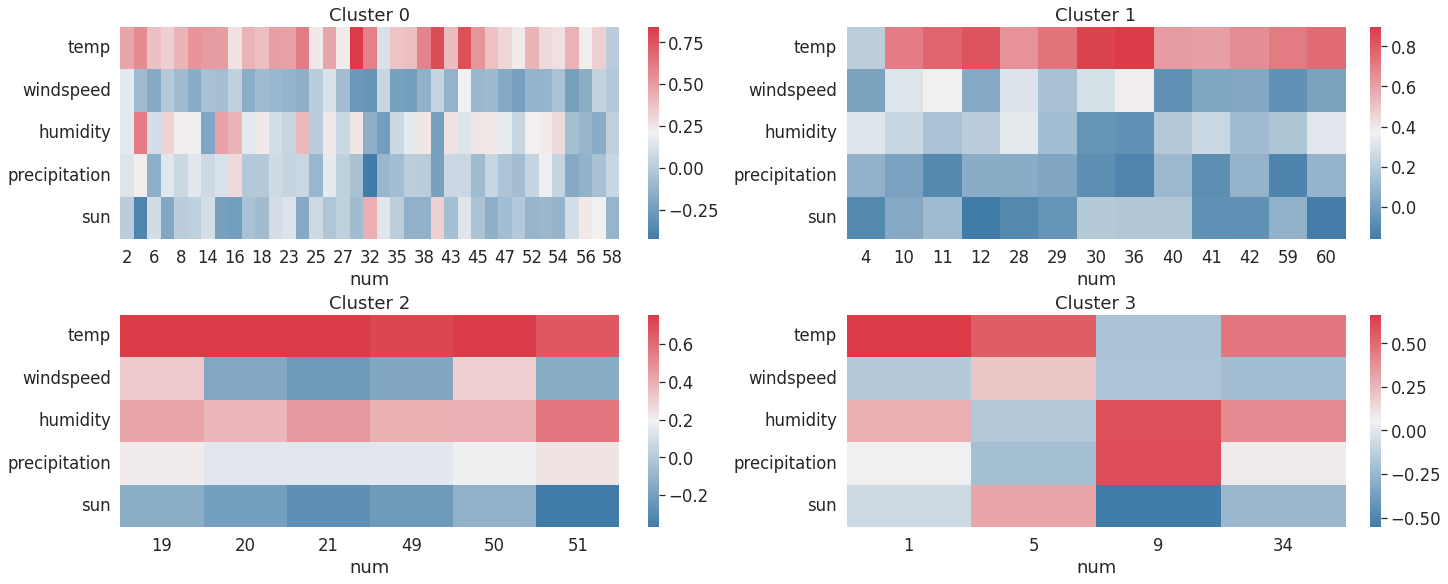

In [61]:
corrs4 = []
for c in range(4):
    data = new_train[new_train['cluster'] == c]
    nums = data['num'].unique()
    data = data.groupby(['num', 'date'])[['energy','temp','windspeed','humidity','precipitation','sun']].mean().reset_index()
    
    corrs = []
    for num in nums:
        corr = []
        corr.append(num)
        for col in ['temp','windspeed','humidity','precipitation','sun']:
            corr.append(spearmanr(data.loc[data.num == num, 'energy'], data.loc[data.num == num, col]).correlation)
        corrs.append(corr)
    corrs4.append(corrs)


fig = plt.figure(figsize = (20, 8), constrained_layout=True)
for i, corrs in enumerate(corrs4):
    data = pd.DataFrame(np.array(corrs), columns = ['num','temp','windspeed','humidity','precipitation','sun'])
    data['num'] = data['num'].astype(int)
    data = data.set_index('num')

    sns.set(font_scale = 1.5)
    plt.subplot(2, 2, i+1)
    sns.heatmap(data.transpose(), cmap = sns.diverging_palette(240,10, as_cmap = True))
    plt.title(f'Cluster {i}')